# MDplus Hackathon - DistilBERT Fine-Tuning

First, we install relevant packages.

In [1]:
!pip install datasets evaluate together --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 5.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux

In [12]:
# Imports
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

import datasets
from datasets import Dataset, DatasetDict

import evaluate
import numpy as np

from google.colab import files
import shutil

import torch
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from scipy.special import softmax
from torch.utils.data import DataLoader
from datasets import Dataset
from sklearn.utils import resample
from tqdm import tqdm

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from itertools import cycle
import matplotlib.pyplot as plt
import wandb

# Load dataset

In [3]:
ds = datasets.load_dataset("mdplus/Datathon2024", data_dir="mentalhealth")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

swmh_train.jsonl:   0%|          | 0.00/42.6M [00:00<?, ?B/s]

swmh_test.jsonl:   0%|          | 0.00/10.5M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [4]:
train_df = ds["train"].to_pandas()
test_df = ds["test"].to_pandas()

print(f"Train: {len(train_df)}, Test: {len(test_df)}")

Train: 43529, Test: 10883


In [5]:
# Remove off my chest entries
filtered_train_df = train_df[train_df["label"] != "off_my_chest"]
filtered_test_df = test_df[test_df["label"] != "off_my_chest"]

print(f"Train: {len(filtered_train_df)}, Test: {len(filtered_test_df)}")
print(f"Train labels: {filtered_train_df['label'].unique()}")

Train: 36932, Test: 9196
Train labels: ['anxiety' 'bipolar' 'depression' 'suicide_watch']


In [7]:
# Turn text labels into categorical labels
print(filtered_train_df.columns)

Index(['text', 'label'], dtype='object')


In [6]:
# Define categorical map for ids
id2label = {0: "anxiety", 1: "bipolar", 2: "depression", 3: "suicide_watch"}
label2id = {v:k for k, v in id2label.items()}

# Convert labels in DataFrame to id
filtered_train_df["label"] = filtered_train_df["label"].map(label2id)
filtered_test_df["label"] = filtered_test_df["label"].map(label2id)

<ipython-input-6-c2caca07552c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_train_df["label"] = filtered_train_df["label"].map(label2id)
<ipython-input-6-c2caca07552c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_test_df["label"] = filtered_test_df["label"].map(label2id)


# Preprocess dataset

In [8]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [9]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [10]:
# Convert train and test DataFrames to Hugging Face Datasets
train_ds = Dataset.from_pandas(filtered_train_df)
test_ds = Dataset.from_pandas(filtered_test_df)

In [13]:
# Split train dataset into training and validation sets (80% train, 20% validation)
train_df, val_df = train_test_split(filtered_train_df, test_size=0.2, random_state=42)

In [14]:
# Convert to Hugging Face Dataset objects
train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)

In [15]:
#Tokenize the Datasets
tokenized_train_ds = train_ds.map(preprocess_function, batched=True)
tokenized_val_ds = val_ds.map(preprocess_function, batched=True)
tokenized_test_ds = test_ds.map(preprocess_function, batched=True)

Map:   0%|          | 0/29545 [00:00<?, ? examples/s]

Map:   0%|          | 0/7387 [00:00<?, ? examples/s]

Map:   0%|          | 0/9196 [00:00<?, ? examples/s]

In [16]:
# Rename the label column if necessary
tokenized_train_ds = tokenized_train_ds.rename_column("label", "labels")
tokenized_val_ds = tokenized_val_ds.rename_column("label", "labels")
tokenized_test_ds = tokenized_test_ds.rename_column("label", "labels")

# Set format for PyTorch, keeping only the necessary columns
tokenized_train_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_val_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_test_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

In [20]:
# Step 5: Create a DatasetDict for the Trainer (Place it here ✅)
dataset = DatasetDict({
    "train": tokenized_train_ds,
    "validation": tokenized_val_ds,
    "test": tokenized_test_ds
})

# Now you can pass `dataset["train"]` and `dataset["validation"]` to the Trainer

# Define model

In [21]:
# Create a batch of examples
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [22]:
# Define model (4 output labels)
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=4)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Define evaluation

In [23]:
# Load the metrics (for real-time training evaluation only)
accuracy = evaluate.load("accuracy")

# Define the compute_metrics function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": accuracy.compute(predictions=predictions, references=labels)["accuracy"]}

# Train model

In [29]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [30]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="mdplus_textclassification_DN",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",  # Fixed parameter name
    save_strategy="epoch",
    save_total_limit=2,  # Prevents excessive checkpoint storage
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",  # Ensures best model selection
    greater_is_better=False,  # Lower loss is better
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_val_ds,  # Use validation set instead of test set
    tokenizer=tokenizer,  # Fixed incorrect parameter name
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-30-e2717967f2ff>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [31]:
trainer.train()

<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: kadenbunch (kadenbunch-brown-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,0.639100,0.601574,0.762150
2,0.470500,0.623572,0.762691


TrainOutput(global_step=3694, training_loss=0.5355232478349868, metrics={'train_runtime': 2845.6293, 'train_samples_per_second': 20.765, 'train_steps_per_second': 1.298, 'total_flos': 7430651183827200.0, 'train_loss': 0.5355232478349868, 'epoch': 2.0})

# Download model

In [32]:


folder_path = '/content/mdplus_textclassification_DN'
zip_path = '/content/mdplus_textclassification_DN.zip'

shutil.make_archive(zip_path.replace('.zip', ''), 'zip', folder_path)

files.download(zip_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Post-mortem evaluation

In [34]:
!ls /content/mdplus_textclassification_DN/


checkpoint-1847  checkpoint-3694  runs


In [36]:
checkpoint_directory = "/content/mdplus_textclassification_DN/checkpoint-3694".strip()

# Check if the folder exists
!ls /content/mdplus_textclassification_DN/checkpoint-3694

# Load model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained(checkpoint_directory)
tokenizer = AutoTokenizer.from_pretrained(checkpoint_directory)


config.json	   rng_state.pth	    tokenizer_config.json  training_args.bin
model.safetensors  scheduler.pt		    tokenizer.json	   vocab.txt
optimizer.pt	   special_tokens_map.json  trainer_state.json


In [37]:
# Place model in evaluation mode; use GPU where avail.
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Prepare the DataLoader with DataCollatorWithPadding
# Use DataCollatorWithPadding to handle varying sequence lengths in batches
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
test_loader = DataLoader(tokenized_test_ds, batch_size=16, collate_fn=data_collator)

In [38]:
# Run preds
all_logits = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        all_logits.append(logits.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate results
all_logits = np.concatenate(all_logits, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Convert logits to probabilities and predictions
proba = softmax(all_logits, axis=1)  # Convert logits to probabilities
preds = np.argmax(all_logits, axis=1)  # Predicted class labels

# Compute metrics using sklearn
accuracy = accuracy_score(all_labels, preds)
f1 = f1_score(all_labels, preds, average="weighted")
precision = precision_score(all_labels, preds, average="weighted")
recall = recall_score(all_labels, preds, average="weighted")
auroc = roc_auc_score(all_labels, proba, multi_class="ovr", average="weighted")

# Step 6: Print out the results
print("Evaluation Metrics on Test Set:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"AUROC (OvR): {auroc:.4f}")


Evaluation Metrics on Test Set:
Accuracy: 0.7569
F1 Score (weighted): 0.7576
Precision (weighted): 0.7602
Recall (weighted): 0.7569
AUROC (OvR): 0.9129


In [39]:
# Number of bootstraps and confidence level
n_bootstraps = 1000
confidence_level = 0.95

# Collect all logits and labels with a single inference pass
all_logits = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        all_logits.append(logits.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate results for full test set
all_logits = np.concatenate(all_logits, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Convert logits to probabilities and make initial predictions
all_proba = softmax(all_logits, axis=1)
all_preds = np.argmax(all_logits, axis=1)

# Bootstrapping function for confidence intervals
def calculate_confidence_interval(data):
    lower_bound = np.percentile(data, ((1 - confidence_level) / 2) * 100)
    upper_bound = np.percentile(data, (1 - (1 - confidence_level) / 2) * 100)
    return np.mean(data), (lower_bound, upper_bound)

# Perform bootstrapping on stored predictions and labels
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []
auroc_scores = []

for i in tqdm(range(n_bootstraps), desc="Bootstrapping Metrics"):
    # Resample predictions and labels with replacement
    proba_resampled, labels_resampled = resample(all_proba, all_labels, random_state=i)
    preds_resampled = np.argmax(proba_resampled, axis=1)

    # Calculate metrics for resampled predictions
    accuracy_scores.append(accuracy_score(labels_resampled, preds_resampled))
    f1_scores.append(f1_score(labels_resampled, preds_resampled, average="weighted"))
    precision_scores.append(precision_score(labels_resampled, preds_resampled, average="weighted"))
    recall_scores.append(recall_score(labels_resampled, preds_resampled, average="weighted"))
    auroc_scores.append(roc_auc_score(labels_resampled, proba_resampled, multi_class="ovr", average="weighted"))


Bootstrapping Metrics: 100%|██████████| 1000/1000 [00:18<00:00, 53.16it/s]


In [40]:
# Organize results in the format expected
bootstrapped_results = {
    checkpoint_directory: {
        'Accuracy': calculate_confidence_interval(accuracy_scores),
        'AUROC': calculate_confidence_interval(auroc_scores),
        'F1 Score': calculate_confidence_interval(f1_scores),
        'Precision': calculate_confidence_interval(precision_scores),
        'Recall': calculate_confidence_interval(recall_scores)
    }
}

# Step 5: Print out bootstrapped results in the specified format
for model_name, metrics in bootstrapped_results.items():
    print(f"\nResults for {model_name}:")
    for metric_name, (mean_score, ci) in metrics.items():
        print(f"{metric_name}: {mean_score:.4f} (95% CI: {ci[0]:.4f} - {ci[1]:.4f})")



Results for /content/mdplus_textclassification_DN/checkpoint-3694:
Accuracy: 0.7568 (95% CI: 0.7475 - 0.7664)
AUROC: 0.9128 (95% CI: 0.9081 - 0.9175)
F1 Score: 0.7576 (95% CI: 0.7485 - 0.7670)
Precision: 0.7602 (95% CI: 0.7511 - 0.7694)
Recall: 0.7568 (95% CI: 0.7475 - 0.7664)


# Visualization
Taken from previous notebook

In [41]:
y_proba = softmax(all_logits, axis=1)

lb = LabelBinarizer()
y_test_binarized = lb.fit_transform(all_labels)
n_classes = y_test_binarized.shape[1]

# Define class mapping
class_mapping = id2label

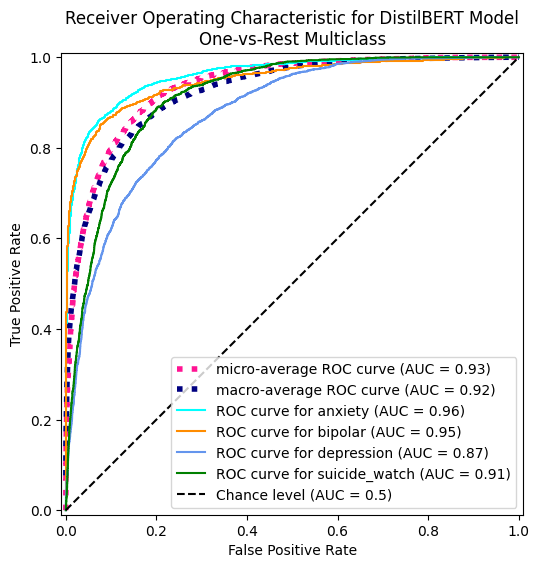

In [42]:
# Initialize the false positive rate, true positive rate, and AUC dictionaries
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# Aggregate all FPR and TPR scores across all classes
all_fpr = np.unique(np.concatenate([roc_curve(y_test_binarized[:, i], y_proba[:, i])[0] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Average TPR and compute AUC for macro-average
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot the figure
fig, ax = plt.subplots(figsize=(6, 6))

# Plot micro-average ROC curve
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

# Plot macro-average ROC curve
plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

# Cycle through colors for each class
colors = cycle(["aqua", "darkorange", "cornflowerblue", "green", "purple"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_test_binarized[:, class_id],
        y_proba[:, class_id],
        name=f"ROC curve for {class_mapping[class_id]}",
        color=color,
        ax=ax,
        plot_chance_level=(class_id == n_classes - 1),  # Chance level plot for the last class
    )

# Configure plot aesthetics
ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Receiver Operating Characteristic for DistilBERT Model\nOne-vs-Rest Multiclass",
)
ax.legend(loc="lower right")


In [43]:
# Save to PDF
output_path = "OvR_ROC_Curves.pdf"
plt.savefig(output_path, format="pdf")

plt.show()

<Figure size 640x480 with 0 Axes>